In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import math 
from __future__ import print_function
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import io
from google.colab import files
from keras.datasets import fashion_mnist
import torch
tf.compat.v1.disable_v2_behavior
tf.compat.v1.disable_eager_execution()

In [ ]:
print(tf.__version__)

2.4.1


Importing

In [ ]:
# Getting AD training data set – for 4 slices, every 88 rows is a new images
uploaded_csv = files.upload() 
training_data_ad = pd.read_csv(io.BytesIO(uploaded_csv['D4_fixed.csv'])) # storing AD dataset in Pandas Dataframe
#print(training_data_ad.shape)


Saving D4_fixed.csv to D4_fixed.csv


In [ ]:
# Getting test training data set
uploaded_csv = files.upload()
training_data_test = pd.read_csv(io.BytesIO(uploaded_csv['D4_fixed_test-1.csv'])) # storing CN dataset in Pandas Dataframe

Saving D4_fixed_test-1.csv to D4_fixed_test-1.csv


In [ ]:
training_data_ad_ = training_data_ad.values


In [ ]:
training_data_test_ = training_data_test.values

Making Label Arrays

In [ ]:
entire_array = []

for j in range(164):
  batch_5 = []
  q = 5*j
  for i in range(5):
    batch_5.append(training_data_ad_[q])
    q+=1
  entire_array.append(batch_5)
entire_array = np.array(entire_array)

In [ ]:
entire_array_test = []
for j in range(40):
  batch_5_test = []
  a = 5*j
  for i in range(5):    
    batch_5_test.append(training_data_test_[a])
    a+=1
  entire_array_test.append(batch_5_test)
entire_array_test = np.array(entire_array_test)

In [ ]:
##CREATE TRAINING LABEL ARRAY
label_ad = np.full((82,2), [1, 0], dtype = int)

label_cn = np.full((82,2), [0, 1], dtype = int)

label_all = np.concatenate([label_ad, label_cn])

##RANDOMIZE TRAINING DATA AND LABELS TOGETHER
random_training_data = entire_array
print("entire array:", entire_array.shape)
#random_training_data = tf.convert_to_tensor(random_training_data)
random_labels = label_all

##FIND AND SHUFFLE INDICES
indices = tf.range(start=0, limit=tf.shape(random_training_data)[0], dtype=tf.int32)
ind_shuf = (tf.random.shuffle(indices)).eval(session=tf.compat.v1.Session())

#
random_training_data = tf.gather(random_training_data, ind_shuf)
#random_training_data = [entire_array[i] for i in ind_shuf]
#np.take_along_axis(random_training_data, ind_shuf, axis = 1)
training_data_ad_train = random_training_data.eval(session=tf.compat.v1.Session())    #####TAKE OUT EVAL  


#random_labels = tf.gather(random_labels, ind_shuf)
random_labels = [label_all[i] for i in ind_shuf]
#print("label all shape: ", label_all.shape)

#print(training_data_ad.eval(session=tf.compat.v1.Session()))

#training_data_ad = tf.compat.v1.convert_to_tensor(training_data_ad, dtype = object)
#training_data_ad = np.array(training_data_ad)
#training_data_ad = tf.ragged.constant(training_data_ad)




##TESTING DATA RANDOMIZING
label_ad_test = np.full((20,2), [1, 0], dtype = int)

label_cn_test = np.full((20,2), [0, 1], dtype = int)

label_all_test = np.concatenate([label_ad_test, label_cn_test])
#print("test labels shape: ", label_all_test.shape)


random_training_data_test = entire_array_test

random_labels = label_all_test

indices = tf.range(start=0, limit=tf.shape(random_training_data_test)[0], dtype=tf.int32)
ind_shuf = tf.random.shuffle(indices)
#ind_shuf = ind_shuf.eval(session=tf.compat.v1.Session())

random_training_data_test = tf.gather(random_training_data_test, ind_shuf)

training_data_test = random_training_data_test
#print("test array shape: ", random_training_data_test.shape)
#training_data_test = torch.FloatTensor(training_data_test)
random_labels = tf.gather(random_labels, ind_shuf)

label_all_test = random_labels

entire array: (164, 5, 256)
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Initialization

In [ ]:
ad_size = 419 # number of images in ad training set
cn_size = 424 # number of images in the cn training set
img_height = 250
img_width = 250
init = tf.compat.v1.global_variables_initializer()

Hyperparameters – training iterations, learning rate, and batch size

In [ ]:
training_iterations = 10 # number of times we train the network
learning_rate = 0.001 # factor that is multiplied with the weights based on which weights get updated
batch_size = 5 # number of images in each batch that will be trained at a time (power of 2)

Categorical class labels

In [ ]:
label_dict = {0: 'Alzheimer', 1: 'Cognitively Normal'} 

Shape of Training Set

In [ ]:
print("All training data shape: ", training_data_ad.shape) # getting shape of the AD data
print("Test training data shape: ", training_data_test.shape) # getting shape of the CN data

All training data shape:  (820, 256)
Test training data shape:  (40, 5, 256)


Reshaping

In [ ]:
training_data_ad = tf.reshape(training_data_ad, [-1, 16, 16, 1])
training_data_test = tf.reshape(training_data_test, [-1, 16, 16, 1])

In [ ]:
print("AD training data shape: ", training_data_ad.shape) # getting shape of the AD data
print("CN training data shape: ", training_data_test.shape) # getting shape of the CN data

AD training data shape:  (820, 16, 16, 1)
CN training data shape:  (200, 16, 16, 1)


Network Parameters

In [ ]:
n_input = 22 # size of the input
n_classes = 2 # AD vs CN

Placeholders

In [ ]:
x = tf.compat.v1.placeholder("float", [5, 16, 16, 1])
y = tf.compat.v1.placeholder("float", [None,n_classes])

Wrappers

In [ ]:
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    # x = input (placeholder)
    # W = weight
    # b = bias
    # strides = 1 (by defeault)
    #   first and last stride have to always to be 1
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.sigmoid(x)

def maxpool2d(x, k=2):
  # Max Pool function
  # x = input
  # k = kernal size
  # max-pooling filter will be square matrix of k x k dimensions
  # Filter will move in strides of k
  # also downsamples
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')

tf.compat.v1.get_variable_scope().reuse_variables()
with tf.compat.v1.variable_scope('idk', reuse=tf.compat.v1.AUTO_REUSE) as scope:

  weights = {
      'wc1': tf.compat.v1.get_variable('W30', shape=(7,7,1,32), initializer=tf.keras.initializers.GlorotNormal()),
      'wc2': tf.compat.v1.get_variable('W12', shape=(3,3,32,64), initializer=tf.keras.initializers.GlorotNormal()),
      'wc3': tf.compat.v1.get_variable('W31', shape=(1,1,64,128), initializer=tf.keras.initializers.GlorotNormal()),      
      'wd1': tf.compat.v1.get_variable('W19', shape=(2*2*128,128), initializer=tf.keras.initializers.GlorotNormal()),
      'out': tf.compat.v1.get_variable('W22', shape=(128, n_classes), initializer=tf.keras.initializers.GlorotNormal()),
}

  biases = {
      'bc1': tf.compat.v1.get_variable('B6', shape=(32), initializer=tf.keras.initializers.GlorotNormal()),
      'bc2': tf.compat.v1.get_variable('B7', shape=(64), initializer=tf.keras.initializers.GlorotNormal()),
      'bc3': tf.compat.v1.get_variable('B8', shape=(128), initializer=tf.keras.initializers.GlorotNormal()),
      'bd1': tf.compat.v1.get_variable('B12', shape=(128), initializer=tf.keras.initializers.GlorotNormal()),
      'out': tf.compat.v1.get_variable('B13', shape=(2), initializer=tf.keras.initializers.GlorotNormal()),
}

In [ ]:
def conv_net(x, weights, biases): 
  conv1 = conv2d(x, weights['wc1'], biases['bc1'])
  conv1 = maxpool2d(conv1, k=2)

  conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
  conv2 = maxpool2d(conv2, k=2)

  conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
  conv3 = tf.nn.sigmoid(conv3)

  # Fully Connected Layer
  fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
  fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
  fc1 = tf.nn.sigmoid(fc1)

  # Output the class prediction
  out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
  return out


#Loss and Optimizer Nodes
pred = conv_net(x, weights, biases)

correct_prediction = tf.equal(tf.argmax(pred,0), tf.argmax(y, 0))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))

#Use AdamOptimizer 
with tf.compat.v1.variable_scope('idk', reuse=tf.compat.v1.AUTO_REUSE) as scope:
  optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate, beta1= 0.9, beta2 = 0.99, epsilon=1e-08).minimize(cost)
  init = tf.compat.v1.global_variables_initializer()

In [ ]:
print(training_data_test.shape)
print(label_all.shape)


Testing

In [ ]:
with tf.compat.v1.Session() as sess:
  sess.run(init)
  train_loss = []
  test_loss = []
  train_accuracy = []
  test_accuracy_real = []
  
  #Run 7 training iterations of the entire data set
  for i in range(training_iterations):
    batch_acc = []
    batch_loss = []
    batch_acc_testing = []
    batch_loss_testing = []
    for batch in range(training_data_ad.shape[0]//batch_size):
      #batch x = 5 all_data images
      #batch y = output/labels
      batch_x = training_data_ad[batch*batch_size:min((batch+1)*batch_size,training_data_ad.shape[0])]
      
      batch_y = label_all[batch:min((batch+1),len(label_all))]

      opt = sess.run(optimizer, feed_dict={x:batch_x.eval(), y:batch_y})

      #collect loss and acc results for batch
      loss, acc = sess.run([cost, accuracy], feed_dict = {x:batch_x.eval(), y:batch_y})

      #add acc and loss 
      batch_acc.append(acc)
      batch_loss.append(loss)


    for batch in range(training_data_test.shape[0]//batch_size):
      
      batch_x_test = training_data_test[batch*batch_size:min((batch+1)*batch_size,training_data_test.shape[0])]
      batch_y_test = label_all_test[batch:min((batch+1),label_all_test.shape[0])]

      #run test data every iteration 
      #test_X = training_data_test
      #test_y = label_all_test

      valid_loss, test_acc = sess.run([cost, accuracy], feed_dict={x: batch_x_test.eval(),y : batch_y_test.eval()})
      batch_acc_testing.append(test_acc)
      batch_loss_testing.append(valid_loss)

    loss_batch = np.mean(batch_loss)
    train_loss.append(loss_batch)
    acc_batch = np.mean(batch_acc)
    train_accuracy.append(acc_batch)

    test_accuracy = np.mean(batch_acc_testing)
    test_accuracy_real.append(test_accuracy)

    valid_loss = np.mean(batch_loss_testing)
    test_loss.append(valid_loss)

    print("Iter " + str(i) + ", Loss= " + \
                  "{:.6f}".format(loss_batch) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc_batch))
    print("Validation Accuracy:","{:.5f}".format(test_accuracy))
    print("Optimization Finished!")



#graph results
plt.plot(range(len(train_loss)), train_loss, 'b', label='Training loss')
plt.plot(range(len(test_loss)), test_loss, 'r', label='Test Loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()

plt.plot(range(len(train_accuracy)), train_accuracy, 'b', label='Training Accuracy')
plt.plot(range(len(test_accuracy_real)), test_accuracy_real, 'r', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.legend()
plt.figure()
plt.show()

Iter 0, Loss= 0.285699, Training Accuracy= 0.07622
Validation Accuracy: 0.10000
Optimization Finished!
Iter 1, Loss= 1.595523, Training Accuracy= 0.09451
Validation Accuracy: 0.05000
Optimization Finished!
Iter 2, Loss= 0.702361, Training Accuracy= 0.00915
Validation Accuracy: 0.00000
Optimization Finished!
Iter 3, Loss= 0.705951, Training Accuracy= 0.09756
Validation Accuracy: 0.00000
Optimization Finished!
Iter 4, Loss= 0.699657, Training Accuracy= 0.08841
Validation Accuracy: 0.00000
Optimization Finished!


KeyboardInterrupt: ignored

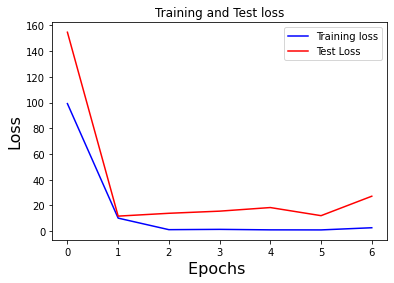

<Figure size 432x288 with 0 Axes>

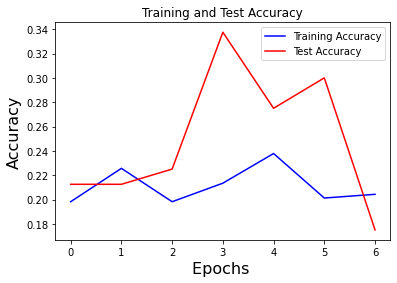

<Figure size 432x288 with 0 Axes>

In [ ]:
#graph results
plt.plot(range(len(train_loss)), train_loss, 'b', label='Training loss')
plt.plot(range(len(test_loss)), test_loss, 'r', label='Test Loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()

plt.plot(range(len(train_accuracy)), train_accuracy, 'b', label='Training Accuracy')
plt.plot(range(len(test_accuracy_real)), test_accuracy_real, 'r', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.legend()
plt.figure()
plt.show()